In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Loading the pre-processed data
amazon_data = pd.read_csv('final_data.csv')
amazon_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...
3,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...
4,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,b'got wild hair taffi order five pound bag taf...


### Sorting the data based on timestamps

In [3]:
balanced_sorted_data = amazon_data.sort_values(by='Time',kind='quicksort',ascending=True,inplace=False,axis=0).reset_index(drop=True)
balanced_sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth act spe...
1,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
2,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
3,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
4,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain hesit pick ...


In [4]:
#Getting the class labels
balanced_data_score = balanced_sorted_data['Score']
balanced_data_score.shape

(364137,)

In [7]:
#Dropping the score column from the main data
balanced_sorted_data = balanced_sorted_data.drop(['Score'],axis=1)
balanced_sorted_data.shape

(364137, 10)

In [8]:
#Building the train and test data
balanced_train_data = balanced_sorted_data.iloc[:140000]
balanced_train_score = balanced_data_score[:140000]
balanced_test_data = balanced_sorted_data.iloc[140000:200000]
balanced_test_score = balanced_data_score[140000:200000]

# Word2Vec

In [9]:
import re
#Cleaning the html tags
def cleanHtml(sentence):
    cleanText = re.sub('<.*?>','',sentence)
    return cleanText
#Removing Punctuations
def cleanPunc(word):
    cleaned = re.sub(r'[#|!|?|\'|@|"]','',word)
    cleaned = re.sub(r'[,|.|(|)|\|/]',' ',word)
    return cleaned

In [10]:
train_test_data = balanced_sorted_data.iloc[:200000]

In [11]:
#Filtering the sentences for using in word2vec
from gensim.models import Word2Vec
final_sentences = []
for sentence in balanced_sorted_data.Text.values:    
    sent = cleanHtml(sentence)       #Cleaning the html tags from the sentences
    filtered_sentence = []           #The filtered sentences to be stored in this list
    for word in sent.split():    #Looping through each word
        for cleaned_word in cleanPunc(word).split():   #Cleaning the punctuations from each word
            if(cleaned_word.isalpha()):              
                filtered_sentence.append(cleaned_word.lower())   #Converting the cleaned word to lowercase
            else:
                continue
    final_sentences.append(filtered_sentence)      #Inserting each filtered sentence to the final list

F:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
len(final_sentences)

364137

In [13]:
#Training the Word2Vec model
training_sentences = final_sentences[:140000]
w2v_model = Word2Vec(training_sentences,workers=4,size=50)

In [14]:
words = set(w2v_model.wv.vocab)
len(words)

21257

# Average Word2Vec

In [15]:
#Building model for average word2vec
sent_vectors = []
for sentence in final_sentences:    
    sentence_vectors = np.zeros(50)    #Building word vectors and initializing with 0
    count = 0   #Counting the total number of words in the sentence
    for word in sentence:
        try:
            count+=1           
            w2v = w2v_model.wv[word]    #Appling word2vec for each word
            sentence_vectors+=w2v        #Adding word2vec of each word to sentence vectors
        except:
            pass
    sentence_vectors/=count            #Computing average word2vec
    sent_vectors.append(sentence_vectors)

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [16]:
sent_vectors_df = pd.DataFrame(sent_vectors)
sent_vectors_df.shape

(364137, 50)

In [17]:
#Building 70% train and 30% test data
avgw2v_train_data = sent_vectors_df.iloc[:140000]
avgw2v_test_data = sent_vectors_df.iloc[140000:200000]
print(avgw2v_train_data.shape)
avgw2v_test_data.shape

(140000, 50)


(60000, 50)

### 1. Applying GridSearchCV to find the best max_depth

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
grid_params_avgw2v = {'max_depth':[i for i in range(1,10)]}
grid_estimator_avgw2v = DecisionTreeClassifier(min_samples_split=100,min_samples_leaf=30)
grid_clf_avgw2v = GridSearchCV(grid_estimator_avgw2v,grid_params_avgw2v,scoring='accuracy')

In [82]:
grid_clf_avgw2v.fit(avgw2v_train_data,balanced_train_score)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [83]:
grid_clf_avgw2v.best_params_

{'max_depth': 7}

### 2. Finding the error graph with various max_depth

In [84]:
test_score_avgw2v = grid_clf_avgw2v.cv_results_['mean_test_score']
MSE = 1-test_score_avgw2v
MSE

array([0.13431429, 0.13431429, 0.13431429, 0.13420714, 0.13230714,
       0.13154286, 0.12957857, 0.13068571, 0.13112857])

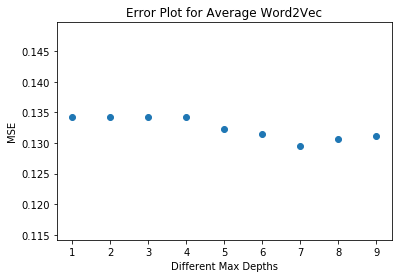

In [85]:
#Plotting thr error graph
plt.scatter(grid_params_avgw2v['max_depth'],MSE)
plt.xlabel('Different Max Depths')
plt.ylabel('MSE')
plt.title('Error Plot for Average Word2Vec')
plt.show()

### 3. Finding the accuracy with train and test data

In [86]:
#Finding the accuracy for test data
from sklearn.metrics import accuracy_score
avgw2v_dt_model = grid_clf_avgw2v.best_estimator_
avgw2v_test_labels = avgw2v_dt_model.predict(avgw2v_test_data)
avgw2v_test_score = accuracy_score(balanced_test_score,avgw2v_test_labels)*float(100)
print("The accuracy of avgw2v model on test data is ---> "+str(avgw2v_test_score))

The accuracy of avgw2v model on test data is ---> 84.90666666666667


In [87]:
#Finding the accuracy with train data
avgw2v_train_labels = avgw2v_dt_model.predict(avgw2v_train_data)
avgw2v_train_score = accuracy_score(balanced_train_score,avgw2v_train_labels)*float(100)
print("The accuracy of avgw2v model on train data is ---> "+str(avgw2v_train_score))

The accuracy of avgw2v model on train data is ---> 87.59642857142858


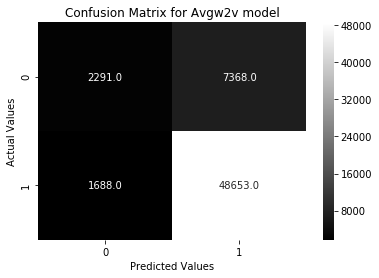

In [88]:
#Building the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
avgw2v_cnf = confusion_matrix(balanced_test_score,avgw2v_test_labels)
sns.heatmap(avgw2v_cnf,fmt='.1f',annot=True,cmap=plt.cm.gray)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for Avgw2v model')
plt.show()

In [89]:
#Finding the tnr,tpr,fnr,fpr
tnr_avgw2v = avgw2v_cnf[0,0]
fpr_avgw2v = avgw2v_cnf[0,1]
fnr_avgw2v = avgw2v_cnf[1,0]
tpr_avgw2v = avgw2v_cnf[1,1]
print("The TNR for Average Word2Vec is "+str(tnr_avgw2v))
print('The FPR for Average Word2Vec is '+str(fpr_avgw2v))
print("The FNR for Average Word2Vec is "+str(fnr_avgw2v))
print("The TPR for Average Word2Vec is "+str(tpr_avgw2v))

The TNR for Average Word2Vec is 2291
The FPR for Average Word2Vec is 7368
The FNR for Average Word2Vec is 1688
The TPR for Average Word2Vec is 48653


In [90]:
#Finding the precision and recall
precision_avgw2v = tpr_avgw2v/(tpr_avgw2v+fpr_avgw2v)
recall_avgw2v = tpr_avgw2v/(tpr_avgw2v+fnr_avgw2v)
print('The precision for Average Word2Vec model is '+str(precision_avgw2v))
print('The recall for Average Word2Vec model is '+str(recall_avgw2v))

The precision for Average Word2Vec model is 0.8684778922189893
The recall for Average Word2Vec model is 0.9664686835779981


In [91]:
#Finding the F1 Score
f1_avgw2v = 2*(precision_avgw2v*recall_avgw2v)/(precision_avgw2v+recall_avgw2v)
print('The F1 Score for Average Word2Vec model is '+str(f1_avgw2v))

The F1 Score for Average Word2Vec model is 0.9148568097628853


### 4. Vizualising the decision tree 

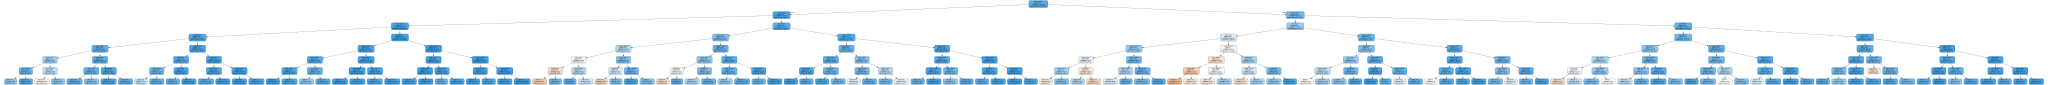

In [92]:
import graphviz 
from sklearn import tree
data = tree.export_graphviz(avgw2v_dt_model,out_file=None, filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(data)
graph

# TFIDF-Weighted Word2Vec

In [93]:
#Taking 10k data points
train_data = balanced_sorted_data.iloc[:7000]
train_test_data = balanced_sorted_data.iloc[:10000]
fin_sentences = final_sentences[:10000]

In [94]:
train_data_score = balanced_train_score[:7000]
test_data_score = balanced_test_score[7000:10000]

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_model = TfidfVectorizer()
tf_idf_model.fit(train_data.Text.values)
tf_idf_model_final = tf_idf_model.transform(train_test_data.Text.values)
tf_idf_model_final.shape

(10000, 19566)

In [96]:
#Building the Weighted TFIDF W2V
tf_features = tf_idf_model.get_feature_names()    #Retrieving the tfidf feature names
weighted_sentences = [];
row = 0;
for sentence in fin_sentences:
    sum_vector = np.zeros(50)     #Building word vectors and initializing with 0
    weighted_sum = 0;             #Initializing the weighted sum to 0
    for word in sentence:         #Looping through each word
        try: 
            w2v = w2v_model.wv[word]         #Applying the word2vec model on each word
            tf_idf = tf_idf_model_final[row,tf_features.index(word)]      #Retrieving the tfidf value for the corresponding word
            sum_vector += (w2v*tf_idf)          #Computing tfidf weighted w2v
            weighted_sum += tf_idf              #Computing the total tfidf weight
        except:
            pass
    sum_vector/=weighted_sum              #Final tfidf weighted w2v
    weighted_sentences.append(sum_vector)
    row += 1 

In [97]:
#Converting the weighted sentences list to a DataFrame
weighted_df = pd.DataFrame(weighted_sentences) 
weighted_df.shape

(10000, 50)

In [98]:
#Building 70% and 30% train-test data set
tfidfw2v_train_data = weighted_df.iloc[0:7000,:]
tfidfw2v_test_data = weighted_df.iloc[7000:10000]
print(tfidfw2v_train_data.shape)
tfidfw2v_test_data.shape

(7000, 50)


(3000, 50)

### 1. Using GridSearchCV to find best max_depth

In [100]:
#Using GridSearchCV to find the best max_depth
grid_params_tfidfw2v = {'max_depth':[i for i in range(1,10)]}
grid_estimator_tfidfw2v = DecisionTreeClassifier(min_samples_split=100,min_samples_leaf=30)
grid_clf_tfidfw2v = GridSearchCV(grid_estimator_tfidfw2v,grid_params_tfidfw2v,scoring='accuracy')

In [101]:
grid_clf_tfidfw2v.fit(tfidfw2v_train_data,train_data_score)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [102]:
grid_clf_tfidfw2v.best_params_

{'max_depth': 1}

### 2. Plotting the error graph with various max_depths

In [103]:
mean_test_score_tfidfw2v = grid_clf_tfidfw2v.cv_results_['mean_test_score']
MSE = 1-mean_test_score_tfidfw2v
MSE

array([0.11585714, 0.11585714, 0.11585714, 0.12042857, 0.11985714,
       0.11614286, 0.11728571, 0.11642857, 0.11642857])

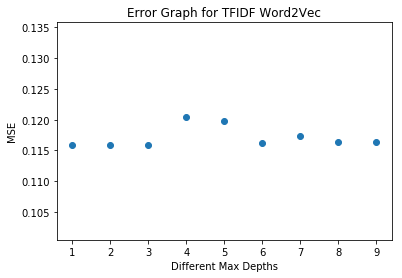

In [104]:
#Plotting the error graph
plt.scatter(grid_params_tfidfw2v['max_depth'],MSE)
plt.xlabel('Different Max Depths')
plt.ylabel('MSE')
plt.title('Error Graph for TFIDF Word2Vec')
plt.show()

### 3. Finding the accuracy with train and test data

In [105]:
tfidfw2v_dt_model = grid_clf_tfidfw2v.best_estimator_
tfidfw2v_test_label = tfidfw2v_dt_model.predict(tfidfw2v_test_data)
tfidfw2v_test_score = accuracy_score(tfidfw2v_test_label,test_data_score)*float(100)
print('The accuracy of TFIDF Word2Vec model with test data is---> '+str(tfidfw2v_test_score))

The accuracy of TFIDF Word2Vec model with test data is---> 84.23333333333333


In [106]:
#Finding accuracy for train data
tfidfw2v_train_label = tfidfw2v_dt_model.predict(tfidfw2v_train_data)
tfidfw2v_train_score = accuracy_score(tfidfw2v_train_label,train_data_score)*float(100)
print('The accuracy of TFIDF Word2Vec model with train data is---> '+str(tfidfw2v_train_score))

The accuracy of TFIDF Word2Vec model with train data is---> 88.41428571428571


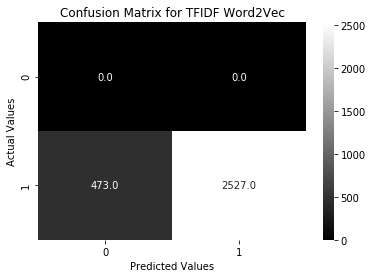

In [107]:
#Building the confusion matrix
tfidfw2v_cnf = confusion_matrix(tfidfw2v_test_label,test_data_score)
sns.heatmap(tfidfw2v_cnf,annot=True,fmt='.1f',cmap=plt.cm.gray)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for TFIDF Word2Vec')
plt.show()

In [108]:
#Finding the tnr,fnr,fpr,tpr
tnr_tfidfw2v = tfidfw2v_cnf[0,0]
fpr_tfidfw2v = tfidfw2v_cnf[0,1]
fnr_tfidfw2v = tfidfw2v_cnf[1,0]
tpr_tfidfw2v = tfidfw2v_cnf[1,1]
print("The TNR for Average Word2Vec is "+str(tnr_tfidfw2v))
print('The FPR for Average Word2Vec is '+str(fpr_tfidfw2v))
print("The FNR for Average Word2Vec is "+str(fnr_tfidfw2v))
print("The TPR for Average Word2Vec is "+str(tpr_tfidfw2v))

The TNR for Average Word2Vec is 0
The FPR for Average Word2Vec is 0
The FNR for Average Word2Vec is 473
The TPR for Average Word2Vec is 2527


In [109]:
#Finding the precision and recall
precision_tfidfw2v = tpr_tfidfw2v/(tpr_tfidfw2v+fpr_tfidfw2v)
recall_tfidfw2v = tpr_tfidfw2v/(tpr_tfidfw2v+fnr_tfidfw2v)
print('The Precision with TFIDF Word2Vec is ---> '+str(precision_tfidfw2v))
print('The Recall with TFIDF Word2Vec is ---> '+str(recall_tfidfw2v))

The Precision with TFIDF Word2Vec is ---> 1.0
The Recall with TFIDF Word2Vec is ---> 0.8423333333333334


In [110]:
#Finding the F1 Score
f1_tfidfw2v = (2*precision_tfidfw2v*recall_tfidfw2v)/(precision_tfidfw2v+recall_tfidfw2v)
print('The F1 Score with TFIDF Word2Vec is --- > '+str(f1_tfidfw2v))

The F1 Score with TFIDF Word2Vec is --- > 0.9144201194137869


### 4. Vizualising the decision tree

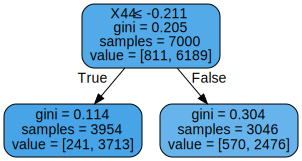

In [111]:
import graphviz
from sklearn import tree
data = tree.export_graphviz(tfidfw2v_dt_model,out_file=None, filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(data)
graph

# Summary

In [112]:
summary = {'model':['Average Word2Vec','TFIDF Weighted Word2Vec'],'best max_depth':[str(grid_clf_avgw2v.best_params_['max_depth']),str(grid_clf_tfidfw2v.best_params_['max_depth'])],'test accuracy':[str(avgw2v_test_score),str(tfidfw2v_test_score)],'train_accuracy':[str(avgw2v_train_score),str(tfidfw2v_train_score)]}
summary_df = pd.DataFrame(summary)
summary_df

,model,best max_depth,test accuracy,train_accuracy
0,Average Word2Vec,7,84.90666666666667,87.59642857142858
1,TFIDF Weighted Word2Vec,1,84.23333333333333,88.41428571428571


# Conclusion: Average Word2Vec model performed the best with Decision Trees